<div>
<img src='https://upload.wikimedia.org/wikipedia/commons/6/64/Sharif_University_Logo.jpg' alt="SUT logo" width=220 height=220 align=left class="saturate">

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<!-- <font color=0F5298 size=7> -->
<font color=0F5298 size=6>
    Introduction to Machine Learning <br> <br>
<!-- <font color=2565AE size=5> -->
<font size=5>
    Computer Engineering Department <br>
    Spring 2023 <br> <br>
<font color=606060 size=5>
    Homeworks 8 & 9 (Combined): Practical - Faces <br> <br>
<font color=686880 size=4>
    TAs: Arman Malekzadeh - Amirhossein Ramazani Bonab - Yalda Shabanzadeh
    
____

### Full Name : Mohammad Javad Maheronnaghsh
___

In this assignment, you'll be dealing with a dataset consisting of 400 faces, belonging to 40 people. Your main task is to train models capable of recognizing those faces.
The faces are `jpg` images packed together as a zip file called `images.zip`, and the `meta.csv` determines from which person each image was taken.

In [5]:
!wget -O images.zip https://www.dropbox.com/s/wrias0bjyte3rr2/images.zip?dl=1
!wget -O meta.csv https://www.dropbox.com/s/vqt1v8sfmz18rcf/faces-metadata.csv?dl=1

--2023-06-27 18:12:12--  https://www.dropbox.com/s/wrias0bjyte3rr2/images.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/wrias0bjyte3rr2/images.zip [following]
--2023-06-27 18:12:13--  https://www.dropbox.com/s/dl/wrias0bjyte3rr2/images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc416c4a6f98a7c2239cd5f9ff51.dl.dropboxusercontent.com/cd/0/get/B-xbl8CJDxMdSDKX__14-XaNQlWeNIHe8Iq0FRDpbyN9M8UE8oBVf_B9u33QDtDV8BztMdFngVbOe2TATuGYwZL7slxH_-QCt-6FRbFXTNfllNpdpqJCSa_esADXef4l2cCJY-t7pjGc8qBRjsE_RGmJNbCKrc2qomCJwzIMG-8EDht0m5UE9bqrwW8Wz-pumf4/file?dl=1# [following]
--2023-06-27 18:12:13--  https://uc416c4a6f98a7c2239cd5f9ff51.dl.dropboxusercontent.com/cd/0/get/B-xbl8CJDxMdSDKX__14-XaNQlWeNIHe8Iq0FRDpbyN9M8UE8oBVf_B9u33QDtD

In [6]:
# you can use the following packages
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import plotly.express as px

# Sec 1: Data Preparation

Load all images as a numpy array (called `x`) and the metadata as a dataframe **(P1-1: 25 points)**




In [7]:
metadata = pd.read_csv('meta.csv')

In [8]:
metadata

,path,label
0,0.jpg,jones
1,1.jpg,jones
2,2.jpg,jones
3,3.jpg,jones
4,4.jpg,jones
...,...,...
395,395.jpg,vaux
396,396.jpg,vaux
397,397.jpg,vaux
398,398.jpg,vaux


In [9]:
import zipfile

with zipfile.ZipFile('images.zip', 'r') as zip_ref:
    zip_ref.extractall('images_folder')

In [10]:
import os

images_folder = 'images_folder/content/img-data'

filenames = sorted(os.listdir(images_folder))

In [11]:
x = []
counter = 0
for filename in filenames:
    image = Image.open(os.path.join(images_folder, filename))
    new_img = np.array(image)
    x.append(new_img)
x = np.array(x)

In [12]:
x.shape

(400, 64, 64)

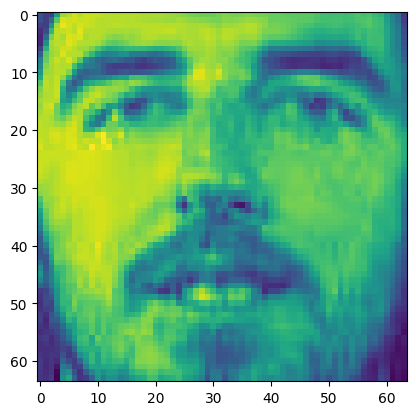

In [13]:
# Visualize a picture
import matplotlib.pyplot as plt
img_array = x[3]
plt.imshow(img_array)
plt.show()

Flatten and normalize the images **(P1-2: 10 points)**

Note: For this part, normalization only means dividing by 255.

In [14]:
x = x / 255.0
# I have flatten it in the next parts

Encode the labels using `LabelEncoder` and save the result as a numpy array called `y` **(P1-3: 5 points)**

In [15]:
# Source: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
le = LabelEncoder()
le.fit(metadata['label'])

LabelEncoder()

In [16]:
len(le.classes_) # Number of people

39

In [17]:
y = le.transform(metadata['label'])

In [18]:
print(len(x))
print(len(y))

400
400


Split the data into training (80%), validation (10%), and testing (10%) parts. **(P1-4: 10 points)**

Note: The split procedure should maintain the class balance. This is sometimes called "[stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling)".

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test)

# Sec 2: SVM

## Subsec 2.1.

Train a SVM using `sklearn`. Note that the hyperparameter tuning should be done using the "validation" set. **(P2-1-1: 20 points)**

In [20]:
x_train.shape

(320, 64, 64)

In [21]:
# Flatten the images
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_val = np.reshape(x_val, (x_val.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))

In [22]:
x_train.shape

(320, 4096)

In [23]:
x_val.shape

(40, 4096)

In [24]:
x_test.shape

(40, 4096)

In [25]:
np.array(sorted(y_val))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 30, 31, 32,
       33, 34, 35, 36, 37, 38])

In [26]:
np.array(sorted(y_test))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 30, 31, 32,
       33, 34, 35, 36, 37, 38])

In [27]:
# import libs
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# First I used GridSearchC, but it wasn't useful, and I tried another way
param_grid = {'C': [0.01, 0.1, 0.2, 1, 2, 3, 10], 'kernel': ('rbf', 'poly', 'linear'), 'degree': [2, 3, 4], 'gamma': ['scale', 'auto', 0.1, 1, 2, 3, 4, 10]}

# Here we are going to iterate over all possible hyperparamters for finding the best one
best_set = {'C': '', 'kernel': '', 'degree': 0, 'gamma': 0}
best_accuracy = 0.0
for c in param_grid['C']:
  for kernel in param_grid['kernel']:
    for degree in param_grid['degree']:
      for gamma in param_grid['gamma']:
        svm = SVC(C=c, kernel=kernel, degree = degree, gamma=gamma)
        svm.fit(x_val, y_val)
        predictions_val = svm.predict(x_val)
        accuracy = accuracy_score(y_val, predictions_val)
        if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_set['C']=c
          best_set['kernel']=kernel
          best_set['degree']=degree
          best_set['gamma']=gamma




# best hyperparameters
best_c = best_set['C']
best_kernel = best_set['kernel']
best_degree = best_set['degree']
best_gamma = best_set['gamma']


# train the SVM on the training and validation set
svm_tuned = SVC(C=best_c, kernel=best_kernel, degree = best_degree, gamma=best_gamma)
svm_tuned.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))

SVC(C=0.01, degree=2, gamma=0.1, kernel='poly')

In [132]:
y_preds = svm_tuned.predict(x_test)

Report the accuracy and F1-score of the classifier on the testing set **(P2-1-2: 10 points)**

In [133]:
from sklearn.metrics import f1_score

accuracy = accuracy_score(y_test, y_preds)
print("Accuracy on test set: {:.2f}".format(accuracy))

f1 = f1_score(y_test, y_preds, average='weighted')
print("F1 Score:", f1)

Accuracy on test set: 0.53
F1 Score: 0.44416666666666665


In [30]:
y_test

array([ 2, 30,  1, 11, 28,  5, 32, 33, 35, 16,  7, 25, 31, 14, 23, 22, 17,
       27, 37, 15,  4, 30,  0, 18,  3, 21, 38, 12, 36, 29,  9, 20, 13, 26,
       34,  6, 10,  8, 19, 24])

In [31]:
y_preds

array([33, 30,  1, 36, 31,  5, 32, 33, 35, 16, 21, 15, 28, 14, 23,  8, 38,
       25, 37,  0,  4, 30, 24, 18, 30, 21, 38, 12, 36,  6,  9, 20, 14, 26,
       23,  6, 32, 22, 38, 22])

## Subsec 2.2.

Train a SVM from scratch using the following class **(P2-2-1: 40 points)**

Note: For this part, you are not required to use the validation set for hyperparameter tuning. However, you might get better results if you do that.

In [32]:
# MJ Maheronnaghsh
# one-vs-one approach
class SVM:
    def __init__(self, C=1.0, kernel='linear',
                 batch_size=100, learning_rate=0.001, epochs=30):
        self.C = C
        self.kernel = kernel
        self.classifiers = {}
        self.batch_size=100
        self.learning_rate=0.001
        self.epochs=30

    def hingeloss(self, w, b, x, y):
        reg = 0.5 * np.sum(w * w)

        loss = np.maximum(0, 1 - y * (np.dot(x, w.T) + b))
        loss = reg + self.C * np.mean(loss)

        return loss

    def fit(self, X, Y):
        """Fit the SVM model to dataset X in one-vs-one manner.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        y : array-like of shape (n_samples,)
            Training labels, where `n_samples` is the number of samples.

        Returns
        -------
        self : object
            Returns the instance itself.
        """

        ############ Your Code ############
        # STEPS (For each of the classifiers you would need to train)
        # 1. Setup SVM objective function in QP form
        # 2. Solve the QP problem and get the optimal lagrange multipliers
        # 3. Get support vectors and calculate the weight vector
        batch_size = self.batch_size
        learning_rate = self.learning_rate
        epochs = self.epochs

        unique_classes = np.unique(Y)  # Get unique classes

        for cls in unique_classes:
            # Create binary labels for the current class (1 for the class, -1 for the rest)
            binary_labels = np.where(Y == cls, 1, -1)
            classifier = self.train_binary_classifier(X, binary_labels, batch_size, learning_rate, epochs)
            self.classifiers[cls] = classifier

    def train_binary_classifier(self, X, Y, batch_size, learning_rate, epochs):
        number_of_features = X.shape[1]
        number_of_samples = X.shape[0]
        ids = np.arange(number_of_samples)
        np.random.shuffle(ids)
        w = np.zeros((1, number_of_features))
        b = 0
        losses = []

        for _ in range(epochs):
            l = self.hingeloss(w, b, X, Y)
            losses.append(l)

            for batch_initial in range(0, number_of_samples, batch_size):
                gradw = 0
                gradb = 0

                for j in range(batch_initial, batch_initial + batch_size):
                    if j < number_of_samples:
                        x = ids[j]
                        ti = Y[x] * (np.dot(w, self.kernel_func(X[x])) + b)

                        if ti > 1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += self.C * Y[x] * self.kernel_func(X[x])
                            gradb += self.C * Y[x]

                w = w - learning_rate * w + learning_rate * gradw
                b = b + learning_rate * gradb

        return w, b, losses

    def kernel_func(self, x):
        if self.kernel == 'linear':
            return x
        elif self.kernel == 'poly':
            return x ** 3
        elif self.kernel == 'rbf':
          return np.exp(-np.sum(x.reshape(x.shape[0], -1) ** 2, axis=1))
        else:
            raise ValueError("Unsupported kernel. Please choose 'linear', 'poly', or 'rbf'.")

    def transform(self, X):
        """Fit the model with X and apply the dimensionality reduction on X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        y_pred : ndarray of shape (n_samples)
            Your predictions for the class of each sample
        """
        predictions = []
        for cls, classifier in self.classifiers.items():
            w, b, _ = classifier
            w = w.reshape(-1, X.shape[1])  # Reshape w to match the number of features in X

            prediction = np.dot(self.kernel_func(X), w[0]) + b
            predictions.append(prediction)

        predictions = np.array(predictions)
        y_pred = np.argmax(predictions, axis=0)
        return y_pred


Report the accuracy and F1-score of the classifier on the testing set **(P2-2-2: 10 points)**

In [136]:
param_grid = {'C': [0.01, 0.1, 0.2, 1, 2, 3, 10], 'kernel': ('poly', 'linear')}

# Here we are going to iterate over all possible hyperparamters for finding the best one
best_set = {'C': '', 'kernel': ''}
best_accuracy = 0.0
for c in param_grid['C']:
  for kernel in param_grid['kernel']:

        svm = SVM(C=c, kernel=kernel)
        svm.fit(x_val, y_val)
        predictions_val = svm.transform(x_val)
        accuracy = accuracy_score(y_val, predictions_val)
        if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_set['C']=c
          best_set['kernel']=kernel
          best_set['degree']=degree
          best_set['gamma']=gamma
          print('*****')
          print(c)
          print(kernel)
          print(accuracy)




# best hyperparameters
best_c = best_set['C']
best_kernel = best_set['kernel']

*****
0.01
poly
0.175
*****
0.1
linear
0.425
*****
1
poly
0.725


In [137]:
# train the best SVM on the training and validation set
svm_tuned_own = SVM(C=best_c, kernel=best_kernel)
svm_tuned_own.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
y_preds_own = svm_tuned_own.transform(x_test)
accuracy_own = accuracy_score(y_test, y_preds_own)
print("Accuracy on test set: {:.2f}".format(accuracy_own))
f1 = f1_score(y_test, y_preds_own, average='weighted')
print("F1 Score:", f1)

Accuracy on test set: 0.25
F1 Score: 0.20714285714285713


In [139]:
# MJ Maheronnaghsh
# Using library for optimization
import numpy as np
from cvxopt import matrix, solvers


class SVM3:
    def __init__(self, C=1.0):
        self.C = C
        self.support_vectors = None
        self.support_vector_labels = None
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        # Solve the QP problem for each class against the rest
        self.weights = np.zeros((num_classes, num_features))
        self.bias = np.zeros(num_classes)
        for i in range(num_classes):
            y_binary = np.where(y == i, 1, -1)
            self.weights[i], self.bias[i] = self._solve_qp(X, y_binary)

        # Select the support vectors
        support_vectors = []
        support_vector_labels = []
        for i in range(num_classes):
            mask = np.abs(np.dot(X, self.weights[i]) + self.bias[i]) <= 1
            support_vectors.append(X[mask])
            support_vector_labels.append(y[mask])

        self.support_vectors = np.vstack(support_vectors)
        self.support_vector_labels = np.hstack(support_vector_labels)

    def transform(self, X):
        scores = np.dot(X, self.weights.T) + self.bias
        return np.argmax(scores, axis=1)

    def _solve_qp(self, X, y):
        num_samples, num_features = X.shape

        # Solve the QP problem using cvxopt
        P = matrix(np.outer(y, y) * np.dot(X, X.T))
        q = matrix(-np.ones(num_samples))
        G = matrix(np.vstack([-np.eye(num_samples), np.eye(num_samples)]))
        h = matrix(np.hstack([np.zeros(num_samples), np.ones(num_samples) * self.C]))
        shape = y.reshape(1, -1).shape
        A = matrix(y.reshape(1, -1), shape, 'd')
        # A = A.('float')
        # A = matrix(A, 'd')
        # A = matrix(A, (1, m), 'd')
        b = matrix(np.zeros(1))

        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)

        alpha = np.array(solution['x']).flatten()

        # Calculate the weights and bias
        weights = np.dot(X.T, alpha * y)
        mask = (alpha > 1e-5)
        bias = np.mean(y[mask] - np.dot(X[mask], weights))

        return weights, bias


In [138]:
param_grid = {'C': [0.01, 0.1, 0.2, 1, 2, 3, 10]}

# Here we are going to iterate over all possible hyperparamters for finding the best one
best_set = {'C': '', 'kernel': ''}
best_accuracy = 0.0
for c in param_grid['C']:
        svm = SVM3(C=c)
        svm.fit(x_val, y_val)
        predictions_val = svm.transform(x_val)
        accuracy = accuracy_score(y_val, predictions_val)
        if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_set['C']=c
          best_set['kernel']=kernel
          best_set['degree']=degree
          best_set['gamma']=gamma
          print('*****')
          print(c)
          print(accuracy)




# best hyperparameters
best_c = best_set['C']


*****
0.01
0.95
*****
0.1
1.0


In [140]:
# train the best SVM on the training and validation set
svm_tuned_own2 = SVM3(C=best_c)
svm_tuned_own2.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
y_preds_own2 = svm_tuned_own2.transform(x_test)
accuracy_own2 = accuracy_score(y_test, y_preds_own2)
print("Accuracy on test set: {:.2f}".format(accuracy_own2))
f1 = f1_score(y_test, y_preds_own2, average='weighted')
print("F1 Score:", f1)

Accuracy on test set: 0.53
F1 Score: 0.4416666666666666


# Sec 3: PCA

Fetch all images taken from `jones`, `taylor`, `anderson` and `wilson` (use the `labelencoder` object). Perform PCA from scratch using the following `class` to reduce the dimension of those images to 3. Save the results as a `numpy` array of shape `(40, 3)`. **(P3-1: 30 points)**

In [77]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components_ = None

    def fit(self, X):
        """Fit the model with X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        self.components_ = None

        # Center the data
        X_centered = X - np.mean(X, axis=0)

        # Reshape the centered data if it has more than 2 dimensions
        if X_centered.ndim > 2:
            X_centered = X_centered.reshape(X_centered.shape[0], -1)

        # Calculate the covariance matrix
        cov_matrix = np.cov(X_centered.T)

        # Perform eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        # Sort eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        # Select the top n_components eigenvectors as components
        self.components_ = sorted_eigenvectors[:, :self.n_components]

        return self

    def transform(self, X):
        """Fit the model with X and apply the dimensionality reduction on X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        X_new : ndarray of shape (n_samples, n_components)
            Transformed values.
        """
        assert self.components_ is not None

        # Center the data
        X_centered = X - np.mean(X, axis=0)

        # Project the centered data onto the components
        X_transformed = np.dot(X_centered, self.components_)

        return X_transformed


In [80]:
x_ = x.reshape(x.shape[0], -1)

In [81]:
x_.shape

(400, 4096)

In [82]:
# Encode the labels (Using the LE that we created in the first of all)
selection = ['jones', 'taylor', 'anderson', 'wilson']
y_encoded = le.transform(selection)

# Filter the images for Jones, Taylor, Anderson, and Wilson
selected_indices = np.where(np.isin(y, y_encoded))

selected_images = x_[selected_indices]
selected_labels = y[selected_indices]
filtered_images = selected_images.reshape(selected_images.shape[0], -1)


# Perform PCA dimensionality reduction
pca = PCA(n_components=3)
pca.fit(selected_images)
X_transformed = pca.transform(selected_images)

# Save the transformed data
np.save("transformed_data.npy", X_transformed)


In [84]:
X_transformed.shape

(40, 3)

Use `plotly` to plot these 3D samples. You should use their labels as the determiner of their color. **(P3-2: 10 points)**

In [89]:
import plotly.graph_objects as go
reals = np.real(X_transformed)

fig = go.Figure(data=go.Scatter3d(
    x=reals[:, 0],
    y=reals[:, 1],
    z=reals[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=selected_labels,  # Use labels as the color determiner
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Class')
    )
))

# Set plot title and axis labels
fig.update_layout(
    title="3D Scatter Plot",
    scene=dict(
        xaxis_title='Feature 1',
        yaxis_title='Feature 2',
        zaxis_title='Feature 3'
    )
)

# Show the plot
fig.show()


# Sec 4: K-Means

Using K-means, we want to perform clustering on the 3D samples. Consider 4 clusters. After running the K-means algorithm on the data, determine to which cluster each sample belongs. Then, use `plotly` to plot the 3D samples colored with respect to their clusters. **(P4-1: 15 points)**

In [113]:
class KMeans:
    """
    Fits it on data, then uses predict to get cluster labels.
    """

    def __init__(self, n_clusters=4, max_iter=100):
        """
        YOUR CODE (IF NECESSARY)
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None

    def fit(self, X, y=None):
        """Fits the training data
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Training samples
        y : array-like, shape = [n_samples, n_target_values]
            Target values
        Returns
        -------
        self : object
        """

        n_samples, n_features = X.shape
        """
        YOUR CODE
        """
         # Initialize centroids randomly
        np.random.seed(0)
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        # Perform K-means clustering
        for _ in range(self.max_iter):
            # Assign each sample to the nearest centroid
            distances = self._compute_distances(X)
            labels = np.argmin(distances, axis=1)

            # Update centroids
            new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.n_clusters)])

            # Check for convergence
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

    def predict(self, X):
        """ Predicts the cluster label
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Test samples
        Returns
        -------
        Predicted cluster label
        """

        y_pred = None
        """
        YOUR CODE
        """
        distances = self._compute_distances(X)
        y_pred = np.argmin(distances, axis=1)
        return y_pred
    def _compute_distances(self, X):
        """Compute the Euclidean distances between samples and centroids.
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Samples.
        Returns
        -------
        distances : array-like, shape = [n_samples, n_clusters]
            Distances between samples and centroids.
        """
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return distances

In [118]:
kmeans = KMeans()
kmeans.fit(reals, None)
preds_clusters = kmeans.predict(reals)

In [119]:
preds_clusters

array([2, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2])

In [120]:


fig = go.Figure(data=go.Scatter3d(
    x=reals[:, 0],
    y=reals[:, 1],
    z=reals[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=preds_clusters,  # Use labels as the color determiner
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Class')
    )
))

# Set plot title and axis labels
fig.update_layout(
    title="3D Scatter Plot",
    scene=dict(
        xaxis_title='Feature 1',
        yaxis_title='Feature 2',
        zaxis_title='Feature 3'
    )
)

# Show the plot
fig.show()


Measure the quality of the clustering using "silhoutte score" **(P4-2: 5 points)**

Note: You can use `sklearn` or other packages to calculate the score.

In [141]:
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(reals, preds_clusters)
print("Silhouette Score:", sil_score)


Silhouette Score: 0.42941311495251017


Compare the result of the clustering with the original labels. To be more precise, in this part, you should clearly answer the following questions with details:<br>

- Does each cluster represent a true label?
- What is your conclusion?

**(P4-3: 10 points)**

In [124]:
reals.shape

(40, 3)

In [128]:
set_2 = []
set_17 = []
set_33 = []
set_37 = []

cluster_0 = []
cluster_1 = []
cluster_2 = []
cluster_3 = []
for i in range(reals.shape[0]):
  # add in label sets
  if selected_labels[i] == 2:
    set_2.append(preds_clusters[i])
  elif selected_labels[i] == 17:
    set_17.append(preds_clusters[i])
  elif selected_labels[i] == 33:
    set_33.append(preds_clusters[i])
  elif selected_labels[i] == 37:
    set_37.append(preds_clusters[i])
  # add to cluster sets
  if preds_clusters[i] == 0:
    cluster_0.append(selected_labels[i])
  elif preds_clusters[i] == 1:
    cluster_1.append(selected_labels[i])
  elif preds_clusters[i] == 2:
    cluster_2.append(selected_labels[i])
  elif preds_clusters[i] == 3:
    cluster_3.append(selected_labels[i])


In [129]:
# Observe Clusters
print(cluster_0)
print(cluster_1)
print(cluster_2)
print(cluster_3)

[17, 2, 2, 37, 37]
[33, 33, 33, 33, 33, 33, 2, 2]
[17, 17, 33, 2, 2, 2, 2, 2, 2, 37, 37, 37, 37, 37, 37, 37, 37]
[17, 17, 17, 17, 17, 17, 17, 33, 33, 33]


We can conclude that cluster 4 is somehow showing the 17th person.

but the others are not the same

In [130]:
# Observe People
print(set_2)
print(set_17)
print(set_33)
print(set_37)

[1, 0, 0, 1, 2, 2, 2, 2, 2, 2]
[2, 0, 2, 3, 3, 3, 3, 3, 3, 3]
[3, 3, 3, 2, 1, 1, 1, 1, 1, 1]
[2, 2, 2, 2, 2, 2, 2, 0, 0, 2]


As we concluded before, the 17th person is clustered into the 3rd cluster.

the 37th person is also clustered into 4th cluster, but the 2nd person is clustered into this cluster, too!


Finally, if a cluster consists of a similar number and also that similar number mostly belongs to that cluster, we can conclude this.

Otherwise, its difficult to conclude.


# Sec 5: Neural Net (Optional with Bonus Points)

Reshape the images so that they become of shape `64x64` **(P5-1: 5 points)**

In [91]:
# x is already of this size
x.shape
x_train_nn = np.concatenate((x_train, x_val))
x_train_nn = np.reshape(x_train_nn, (x_train_nn.shape[0], 64, 64))
x_test_nn = np.reshape(x_test, (x_test.shape[0], 64, 64))

In [92]:
print(x_train_nn.shape)
print(x_test_nn.shape)

(360, 64, 64)
(40, 64, 64)


Use different types of augmentation techniques (such as Random Flipping, Random Rotation, etc.) to increase the size of the training dataset. **(P5-2: 10 points)**

In [93]:
from keras.preprocessing.image import ImageDataGenerator

# Load your 320x64x64 numpy array here for training

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,       # Rotate by up to 30 degrees
    width_shift_range=0.1,   # Shift horizontally by up to 10% (width)
    height_shift_range=0.1,  # Shift vertically by up to 10% (height)
    zoom_range=0.2,          # Zoom in/out by up to 20%
    horizontal_flip=True,    # Flip horizontally (p=50%)
    vertical_flip=True,      # Flip vertically (p=50%)
    fill_mode='nearest'      # Fill empty pxls with nearest pixel
)

# Fit the ImageDataGenerator to the training data
x_train_nn_new = np.expand_dims(x_train_nn, axis=-1)
datagen.fit(x_train_nn_new)

# Generate augmented images
batch_size = 36
num_batches = 10
X_augmented = []
for i in range(num_batches):
    batch = x_train_nn_new[i*batch_size:(i+1)*batch_size]
    augmented_batch = datagen.flow(batch, batch_size=batch_size, shuffle=False)
    X_augmented.append(augmented_batch[0])

X_augmented = np.squeeze(X_augmented, axis=-1)
X_augmented = np.reshape(X_augmented, (X_augmented.shape[0]*X_augmented.shape[1], X_augmented.shape[2], X_augmented.shape[3]))

In [94]:
x_train_nn_new = np.concatenate([X_augmented, x_train_nn])
y_train_nn_new = np.concatenate([y_train, y_val, y_train, y_val])

In [95]:
print(x_train_nn_new.shape)
print(y_train_nn_new.shape)

(720, 64, 64)
(720,)


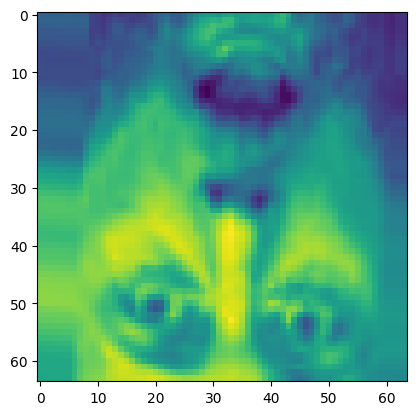

In [96]:
import matplotlib.pyplot as plt
img_array = X_augmented[3]
plt.imshow(img_array)
plt.show()

Using the augmented training set, train a neural network consisting of 2D convolutional layers. The exact architecture of the network is arbitrary. However, the last layer should have the "softmax" function as its activation. Also, using "max pooling" layers after convolutional ones is advised.

Note: Don't get frustrated if your network does not appear to be a good one. Give it some time to be trained. For instance, you might need to train it for 100 epochs. Make sure to try that out before quitting!

**(P5-3: 20 points)**

In [98]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical



# Normalize the input data to have values between 0 and 1
X_train = x_train_nn_new.astype('float32')

# One-hot encode the labels
Y_train = to_categorical(y_train_nn_new)

# Define the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(39, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [103]:
# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.25)

Epoch 1/100
17/17 [==============================] - 4s 239ms/step - loss: 2.2768 - accuracy: 0.3704 - val_loss: 2.7918 - val_accuracy: 0.3222
Epoch 2/100
17/17 [==============================] - 5s 287ms/step - loss: 2.0818 - accuracy: 0.4278 - val_loss: 2.5622 - val_accuracy: 0.3556
Epoch 3/100
17/17 [==============================] - 4s 255ms/step - loss: 1.9625 - accuracy: 0.4500 - val_loss: 2.6249 - val_accuracy: 0.3500
Epoch 4/100
17/17 [==============================] - 4s 231ms/step - loss: 1.7494 - accuracy: 0.5241 - val_loss: 2.5821 - val_accuracy: 0.3889
Epoch 5/100
17/17 [==============================] - 5s 296ms/step - loss: 1.6609 - accuracy: 0.5148 - val_loss: 2.5796 - val_accuracy: 0.3722
Epoch 6/100
17/17 [==============================] - 4s 249ms/step - loss: 1.4696 - accuracy: 0.5648 - val_loss: 2.4998 - val_accuracy: 0.3778
Epoch 7/100
17/17 [==============================] - 4s 230ms/step - loss: 1.4787 - accuracy: 0.5574 - val_loss: 2.8013 - val_accuracy: 0.3611

In [104]:
preds_val = model.predict(x_val.reshape((x_val.shape[0], 64, 64)))
y_val_preds = np.array([np.argmax(preds_val[i]) for i in range(40)])

preds_test = model.predict(x_test.reshape((x_test.shape[0], 64, 64)))
y_test_preds = np.array([np.argmax(preds_test[i]) for i in range(40)])

2/2 [==============================] - 0s 22ms/step


Measure the accuracy of the network on the validation and testing datasets **(P5-4: 5 points)**

In [105]:
print(accuracy_score(y_val, y_val_preds))
print(accuracy_score(y_test, y_test_preds))

0.525
0.425
